In [1]:
from __future__ import division, print_function
import glob

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rosbag_pandas
from scipy.spatial import Voronoi, voronoi_plot_2d

%matplotlib inline

In [3]:
from collections import namedtuple
Coords = namedtuple("Coords", "x y")

In [4]:
from enum import Enum
DroneState = Enum("DroneState",
                  "Emergency Inited Landed Flying Hovering Test TakingOff GotoHover Landing Looping",
                  start=0)

In [5]:
from record_bagfiles import ROSBAG_TOPICS

In [6]:
def remove_image_topics(topics):
    return [topic for topic in topics if topic not in ("/ardrone/past_image", "/ardrone/slow_image_raw")]

In [7]:
TOPICS_TO_LOAD = remove_image_topics(ROSBAG_TOPICS)
TOPICS_TO_LOAD

['/ardrone/ground_pose',
 '/ardrone/imu',
 '/ardrone/navdata',
 '/ardrone/past_pose',
 '/ardrone/pose',
 '/ardrone/tracked',
 '/ardrone/arrived']

In [8]:
TOPICS_SUMMARIZED = [
    "/ardrone/arrived",
    "/ardrone/ground_pose",
    "/ardrone/pose"
]

In [9]:
TARGET_COORD_OFFSETS = [Coords(0, 0), Coords(-1, 3.6), Coords(-2, 1.6)]

In [10]:
def pad_bag(df):
    df.fillna(method="pad", inplace=True)
    df.fillna(method="backfill", inplace=True)

In [11]:
def load_bag(filename, include=TOPICS_TO_LOAD):
    df = rosbag_pandas.bag_to_dataframe(filename, include=include)
    pad_bag(df)
    return df

In [12]:
def plot_xy(df, x="x", y="y", invert_x=True, invert_y=True, s=None, c=None,
            cmap="viridis", alpha=1, show_cbar=True, label=None, line=False):
    """
    Coords in real frame. +x is towards doors, +y is away from table.
    
    """
    if s is not None:
        s = df[s]*25
    if c is not None:
        label = c
        try:
            df[c]
        except KeyError:
            pass
        else:
            c = df[c]
    else:
        if line:
            c = "C0"
        else:
            c = df.index
            label="time"
    
    if line:
        plt.plot(df[x] * (-1 if invert_x else 1), df[y] * (-1 if invert_y else 1), c=c, alpha=alpha)
    else:
        plt.scatter(df[x] * (-1 if invert_x else 1), df[y] * (-1 if invert_y else 1), s=s, c=c, cmap=cmap, alpha=alpha)
        if show_cbar:
            plt.colorbar(label=label)
    plt.axis("equal")

In [13]:
def plot_xy_conditional(df, condition=None, x="x", y="y", invert_x=True, invert_y=True,
                        s=None, c=None, c_condition=None, cmap_condition="viridis", cmap_not_condition="gray",
                        alpha_condition=1, alpha_not_condition=1, show_cbar=True, label=None, line=False):
    if condition is None:
        cmap_not_condition = cmap_condition
    plot_xy(df, x=x, y=y, invert_x=invert_x, invert_y=invert_y,
            s=s, c=c, cmap=cmap_not_condition, alpha=alpha_not_condition, show_cbar=show_cbar, label=label, line=line)
    if condition is not None:
        if line:
            show_cbar = False
            if c_condition is None:
                c = "C0"
            else:
                c = c_condition
        plot_xy(df[condition], x=x, y=y, invert_x=invert_x, invert_y=invert_y,
                s=s, c=c, cmap=cmap_condition, alpha=alpha_condition, show_cbar=show_cbar, label=label)

In [14]:
def plot_targets(df, x="x", y="y", invert_x=True, invert_y=True,
                 target_coords=None, target_coord_offsets=None, target_color="r",
                 show_start=True, show_final=True,
                 scale=100):
    if target_coords is not None and target_coord_offsets is not None:
        raise ValueError("Use either target_coords or target_coord_offsets")
        
    p_init = Coords(df[x][0], df[y][0])
    p_final = Coords(df[x][-1], df[y][-1])
    
    if target_coords is None:
        if target_coord_offsets is None:
            target_coord_offsets = TARGET_COORD_OFFSETS
        target_coords = [Coords(p_init.x - offset.x, p_init.y - offset.y) for offset in target_coord_offsets]
    
    if show_start:
        plt.scatter(-p_init.x, -p_init.y, marker=(5, 0), s=100, c="g")
    for coord in target_coords:
        plt.scatter(coord.x * (-1 if invert_x else 1), coord.y * (-1 if invert_y else 1), marker=(5, 1), s=scale, c="m")    
    if show_final:
        plt.scatter(p_final.x * (-1 if invert_x else 1), p_final.y * (-1 if invert_y else 1), marker=(3, 0), s=scale, c="r")
    plt.axis("equal")

In [15]:
def rename_columns(df):
    df.columns = ["arrived", "angle", "gx", "gy", "qa", "qb", "qc", "qd", "x", "y", "z"]

In [16]:
def normalize_columns(df):
    df["xn"] = df.x - df.x[0]
    df["yn"] = df.y - df.y[0]

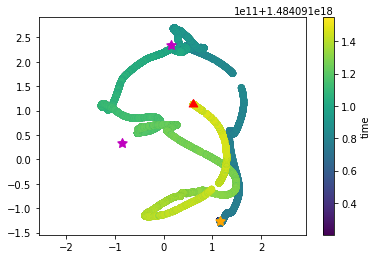

In [126]:
plot_xy(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y")
plot_targets(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y")

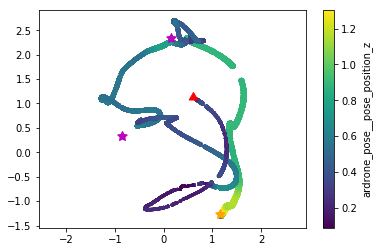

In [127]:
plot_xy(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        s="ardrone_pose__pose_position_z", c="ardrone_pose__pose_position_z")
plot_targets(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y")

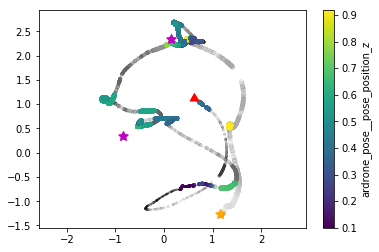

In [128]:
plot_xy(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        s="ardrone_pose__pose_position_z", c="ardrone_pose__pose_position_z", cmap="gray", alpha=0.002, show_cbar=False)
plot_xy(df0[df0.ardrone_navdata__state==DroneState.Hovering.value], "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        s="ardrone_pose__pose_position_z", c="ardrone_pose__pose_position_z")
plot_targets(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y")

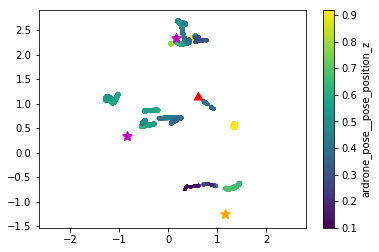

In [129]:
plot_xy(df0[df0.ardrone_navdata__state==DroneState.Hovering.value], "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        s="ardrone_pose__pose_position_z", c="ardrone_pose__pose_position_z")
plot_targets(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y")

In [15]:
df = load_bag("bagfiles/experiment-2_user-00_run-01.bag")

In [16]:
df.columns

Index([u'ardrone_arrived__data', u'ardrone_ground_pose__theta',
       u'ardrone_ground_pose__x', u'ardrone_ground_pose__y',
       u'ardrone_imu__angular_velocity_covariance0',
       u'ardrone_imu__angular_velocity_covariance1',
       u'ardrone_imu__angular_velocity_covariance2',
       u'ardrone_imu__angular_velocity_covariance3',
       u'ardrone_imu__angular_velocity_covariance4',
       u'ardrone_imu__angular_velocity_covariance5',
       u'ardrone_imu__angular_velocity_covariance6',
       u'ardrone_imu__angular_velocity_covariance7',
       u'ardrone_imu__angular_velocity_covariance8',
       u'ardrone_imu__angular_velocity_x', u'ardrone_imu__angular_velocity_y',
       u'ardrone_imu__angular_velocity_z',
       u'ardrone_imu__linear_acceleration_covariance0',
       u'ardrone_imu__linear_acceleration_covariance1',
       u'ardrone_imu__linear_acceleration_covariance2',
       u'ardrone_imu__linear_acceleration_covariance3',
       u'ardrone_imu__linear_acceleration_covariance

In [18]:
target_coords = [Coords(df.ardrone_ground_pose__x[0] - offset.x, df.ardrone_ground_pose__y[0] - offset.y)
                 for offset in TARGET_COORD_OFFSETS]

In [19]:
target_coords

[Coords(x=-0.13781246542930603, y=0.28022757172584534),
 Coords(x=0.86218753457069397, y=-3.3197724282741548),
 Coords(x=1.862187534570694, y=-1.3197724282741548)]

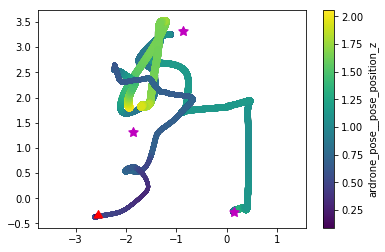

In [20]:
plot_xy(df, "ardrone_ground_pose__x", "ardrone_ground_pose__y", c="ardrone_pose__pose_position_z",
        s="ardrone_pose__pose_position_z")
plot_targets(df, "ardrone_ground_pose__x", "ardrone_ground_pose__y")

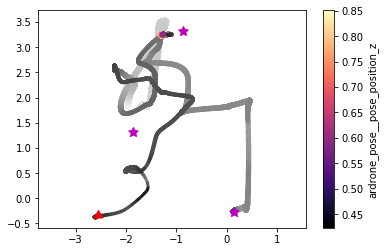

In [21]:
plot_xy(df, "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        s="ardrone_pose__pose_position_z", c="ardrone_pose__pose_position_z", cmap="gray", alpha=0.002, show_cbar=False)
plot_xy(df[df.ardrone_arrived__data==1],
        "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        c="ardrone_pose__pose_position_z", s="ardrone_pose__pose_position_z", cmap="magma")
plot_targets(df, "ardrone_ground_pose__x", "ardrone_ground_pose__y")

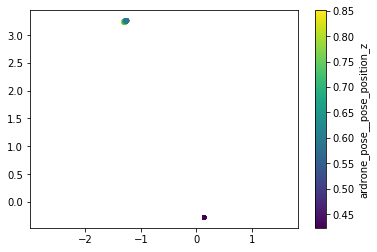

In [22]:
plot_xy(df[df.ardrone_arrived__data==1],
        "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        c="ardrone_pose__pose_position_z", s="ardrone_pose__pose_position_z")

In [23]:
arrived_periods = df[df.ardrone_arrived__data == 1]

In [24]:
duration = df.index[-1] - df.index[0]
duration

Timedelta('0 days 00:02:25.250908')

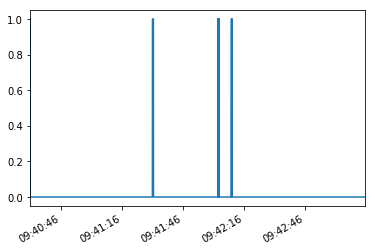

In [25]:
df.ardrone_arrived__data.plot()

In [26]:
len(arrived_periods)

777

In [28]:
a = np.where(np.diff([0, 0, 1, 1, 0, 1, 1, 1, 0, 0]))[0]

In [29]:
a

array([1, 3, 4, 7])

In [30]:
zip(a[::2], a[1::2])

[(1, 3), (4, 7)]

So, the first of each pair is the index of the zero, and the second is that of the last 1.

In [31]:
np.where(np.diff(df.ardrone_arrived__data))

(array([36244, 36690, 69735, 70066]),)

In [32]:
df["angle_degree"] = np.rad2deg(df.ardrone_ground_pose__theta)

In [33]:
df["tag"] = (df.ardrone_arrived__data.diff(1) != 0).astype('int').cumsum()

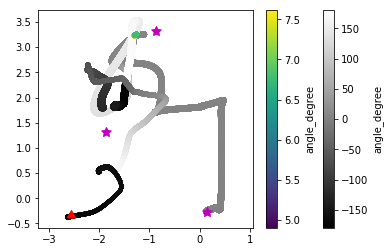

In [34]:
plot_xy(df, "ardrone_ground_pose__x", "ardrone_ground_pose__y", c="angle_degree", s="ardrone_pose__pose_position_z", cmap="gray")
plot_xy(df[df.ardrone_arrived__data == 1], "ardrone_ground_pose__x", "ardrone_ground_pose__y", c="angle_degree", s="ardrone_pose__pose_position_z")
plot_targets(df, "ardrone_ground_pose__x", "ardrone_ground_pose__y")

In [35]:
df0 = df[["ardrone_arrived__data", "ardrone_ground_pose__x", "ardrone_ground_pose__y", "ardrone_pose__pose_position_z", "angle_degree", "tag"]]
df0.columns = ["arrived", "x", "y", "z", "angle", "region"]

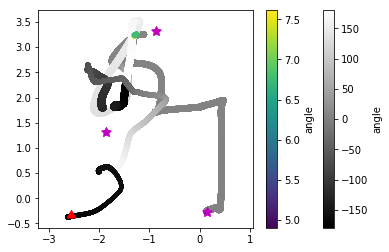

In [36]:
plot_xy(df0, "x", "y", s="z", c="angle", cmap="gray")
plot_xy(df0[df0.arrived==1], "x", "y", s="z", c="angle")
plot_targets(df0, "x", "y")

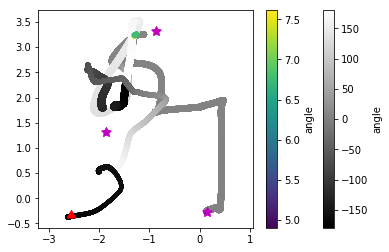

In [37]:
plot_xy_conditional(df0, df0.arrived == 1, s="z", c="angle")
plot_targets(df0, "x", "y")

In [38]:
from scipy.spatial import Voronoi, voronoi_plot_2d

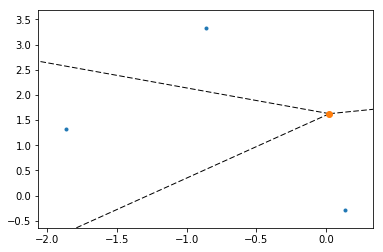

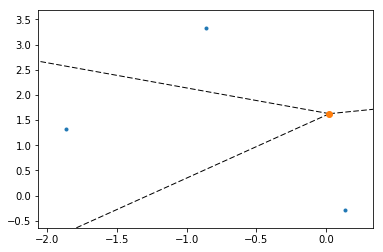

In [46]:
voronoi_plot_2d(Voronoi([[-x, -y] for x, y in target_coords]))

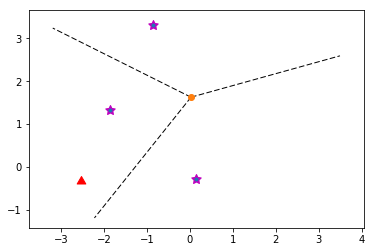

In [40]:
voronoi_plot_2d(Voronoi([[-x, -y] for x, y in target_coords]))
plot_targets(df0, "x", "y")

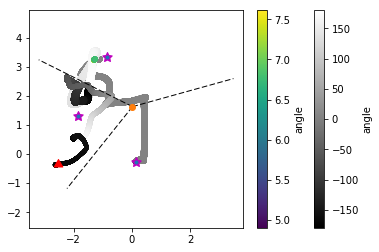

In [41]:
voronoi_plot_2d(Voronoi([[-x, -y] for x, y in target_coords]))
plot_xy_conditional(df0, df0.arrived == 1, s="z", c="angle")
plot_targets(df0, "x", "y")

In [42]:
target_coords

[Coords(x=-0.13781246542930603, y=0.28022757172584534),
 Coords(x=0.86218753457069397, y=-3.3197724282741548),
 Coords(x=1.862187534570694, y=-1.3197724282741548)]

In [69]:
for region, coord in zip(range(2, max(df0.region)+1, 2), target_coords):
    found = df0[df0.region == region]
    diff = Coords(found.x.mean() - coord.x, found.y.mean() - coord.y)
    print("{:.0f}: {} m difference; (dx={:.2f}, dy={:.2f})".format(region/2, np.linalg.norm(diff), diff.x, diff.y))

1: 0.000185314537303 m difference; (dx=-0.00, dy=0.00)
2: 0.424258824514 m difference; (dx=0.42, dy=0.07)


What to do with random presses of arrived? Set a minimum time pressed? Minimum sequence length? Something else?

In [49]:
found = df0[df0.region == 4]
coords = target_coords[1]

In [67]:
rms = np.array([np.sqrt((x - coords.x)**2 + (y - coords.y)**2) for x, y in zip(found.x.values, found.y.values)])

In [73]:
rms.mean()

0.42428997406065783

In [72]:
rms.std()

0.014703301074901167

# Straight line

In [17]:
df = load_bag("bagfiles/experiment-1_user-04_run-03.bag", include=TOPICS_SUMMARIZED)
rename_columns(df)
normalize_columns(df)
df.head()

,arrived,angle,gx,gy,qa,qb,qc,qd,x,y,z,xn,yn
2017-02-03 03:16:15.275017728,0.0,-0.129235,0.018363,2.772829,0.995017,-0.07567,-0.001905,-0.064899,0.018363,2.772829,0.077707,0.0,0.0
2017-02-03 03:16:15.275212032,0.0,-0.129235,0.018363,2.772829,0.995017,-0.07567,-0.001905,-0.064899,0.018363,2.772829,0.077707,0.0,0.0
2017-02-03 03:16:15.283625216,0.0,-0.129235,0.018363,2.772829,0.995017,-0.07567,-0.001905,-0.064899,0.018363,2.772829,0.077707,0.0,0.0
2017-02-03 03:16:15.283373824,0.0,-0.129235,0.018363,2.772829,0.995017,-0.07567,-0.001905,-0.064899,0.018363,2.772829,0.077707,0.0,0.0
2017-02-03 03:16:15.292141056,0.0,-0.129235,0.018363,2.772829,0.995017,-0.07567,-0.001905,-0.064899,0.018363,2.772829,0.077707,0.0,0.0


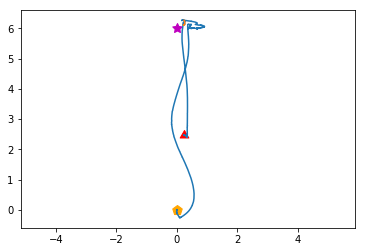

In [86]:
plot_targets(df, x="xn", y="yn", target_coords=[Coords(0, -6)])
plot_xy_conditional(df, df.arrived == 1, x="xn", y="yn", line=True)

In [19]:
plot_xy(df)

KeyError: 'x'

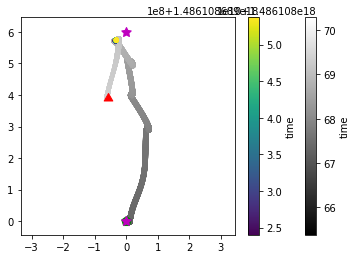

In [32]:
df = load_bag("bagfiles/experiment-0_user-05_run-02.bag", include=TOPICS_SUMMARIZED)
rename_columns(df)
normalize_columns(df)
plot_xy_conditional(df, df.arrived == 1, x="xn", y="yn", s="z")
plot_targets(df, x="xn", y="yn", target_coords=[Coords(0, 0), Coords(0, -6)])

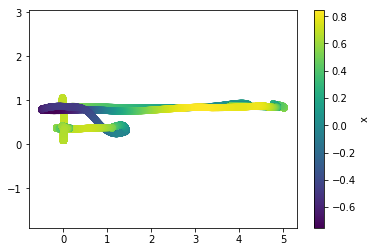

In [26]:
plot_xy(df, x="yn", y="z", invert_y=False, c="x")

In [27]:
df["distance"] = np.sqrt(df.xn**2 + df.yn**2)

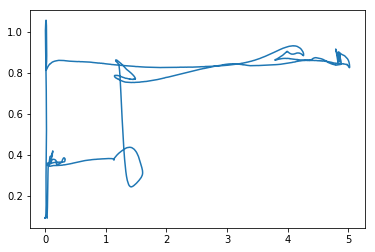

In [28]:
plt.plot(df.distance, df.z)

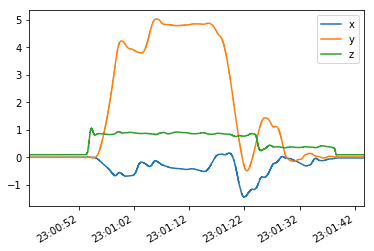

In [29]:
df.xn.plot(label="x")
plt.plot(df.index, -df.yn, label="y")
df.z.plot(label="z")
plt.legend()

# All

(-1, 8)

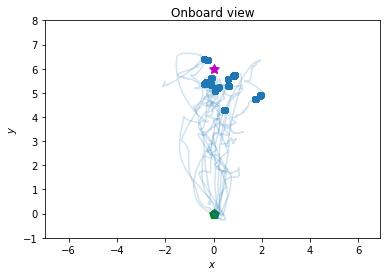

In [150]:
for filename in glob.glob("bagfiles/experiment-0_*.bag"):
    if "user-00" not in filename:
        df = load_bag(filename, include=TOPICS_SUMMARIZED)
        rename_columns(df)
        if any(df.arrived):
            normalize_columns(df)
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", alpha_not_condition=0.2, line=True)
plot_targets(df, x="xn", y="yn", target_coords=[Coords(0, -6)], show_final=False)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Onboard view")
plt.ylim(-1, 8)

(-1, 8)

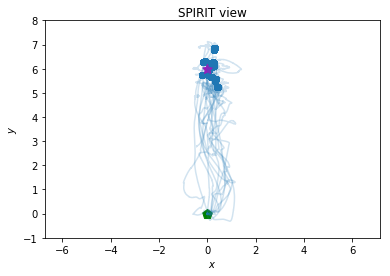

In [151]:
for filename in glob.glob("bagfiles/experiment-1_*.bag"):
    if "user-00" not in filename:
        df = load_bag(filename, include=TOPICS_SUMMARIZED)
        rename_columns(df)
        if any(df.arrived):
            normalize_columns(df)
            plot_xy_conditional(df, df.arrived == 1, x="xn", y="yn", alpha_not_condition=0.2, line=True)
plot_targets(df, x="xn", y="yn", target_coords=[Coords(0, -6)], show_final=False)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("SPIRIT view")
plt.ylim(-1, 8)

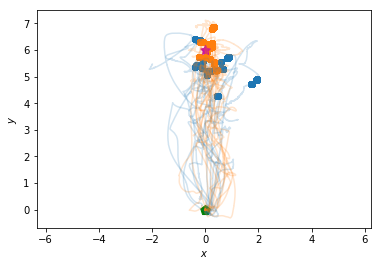

In [148]:
for filename in glob.glob("bagfiles/experiment-0_*.bag"):
    if "user-00" not in filename:
        df = load_bag(filename, include=TOPICS_SUMMARIZED)
        rename_columns(df)
        if any(df.arrived):
            normalize_columns(df)
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C0", c_condition="C0",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True)
for filename in glob.glob("bagfiles/experiment-1_*.bag"):
    if "user-00" not in filename:
        df = load_bag(filename, include=TOPICS_SUMMARIZED)
        rename_columns(df)
        if any(df.arrived):
            normalize_columns(df)
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C1", c_condition="C1",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True)
plot_targets(df, x="xn", y="yn", target_coords=[Coords(0, -6)], show_final=False)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

# Seaborn

In [153]:
import seaborn as sns

In [155]:
df = load_bag("bagfiles/experiment-1_user-05_run-02.bag", include=TOPICS_SUMMARIZED)
rename_columns(df)
normalize_columns(df)

In [160]:
experiments = pd.DataFrame(columns=["user_id", "experiment_type", "run", "rms_mean", "rms_std",
                                    "rms_x_mean", "rms_x_std", "rms_z_mean", "rms_z_std"])

In [ ]:
experiments = pd.DataFrame

In [ ]:
experiments = pd.Dataframe

In [166]:
df.to_csv("csv/experiment-1_user-05_run-02.csv", index_label="time")

In [202]:
df0 = pd.read_csv("csv/experiment-1_user-05_run-02.csv", parse_dates=["time"])
df0.head()

,time,arrived,angle,gx,gy,qa,qb,qc,qd,x,y,z,xn,yn
0,2017-02-03 04:14:32.521745920,0.0,-0.116688,0.016081,2.763059,0.998120,0.018395,0.003106,-0.058377,0.016081,2.763059,0.094384,0.000000,0.000000
1,2017-02-03 04:14:32.521454592,0.0,-0.116688,0.016081,2.763059,0.998120,0.018395,0.003106,-0.058377,0.016081,2.763059,0.094384,0.000000,0.000000
2,2017-02-03 04:14:32.530404608,0.0,-0.124856,0.019033,2.765162,0.998120,0.018395,0.003106,-0.058377,0.016081,2.763059,0.094384,0.000000,0.000000
3,2017-02-03 04:14:32.530204672,0.0,-0.124856,0.019033,2.765162,0.998052,0.000989,-0.000175,-0.062387,0.019033,2.765162,0.091747,0.002952,0.002102
4,2017-02-03 04:14:32.540002560,0.0,-0.124848,0.019053,2.765172,0.998052,0.000989,-0.000175,-0.062387,0.019033,2.765162,0.091747,0.002952,0.002102


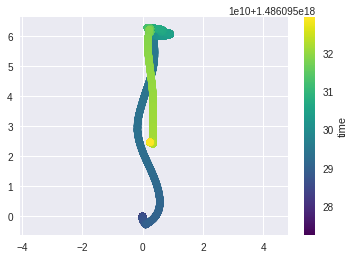

In [203]:
plot_xy(df0, x="xn", y="yn", c="time")

In [186]:
df0

,arrived,angle,gx,gy,qa,qb,qc,qd,x,y,z,xn,yn
time,,,,,,,,,,,,,
2017-02-03 04:14:32.521745920,0.0,-0.116688,0.016081,2.763059,0.998120,0.018395,0.003106,-0.058377,0.016081,2.763059,0.094384,0.000000e+00,0.000000e+00
2017-02-03 04:14:32.521454592,0.0,-0.116688,0.016081,2.763059,0.998120,0.018395,0.003106,-0.058377,0.016081,2.763059,0.094384,0.000000e+00,0.000000e+00
2017-02-03 04:14:32.530404608,0.0,-0.124856,0.019033,2.765162,0.998120,0.018395,0.003106,-0.058377,0.016081,2.763059,0.094384,0.000000e+00,0.000000e+00
2017-02-03 04:14:32.530204672,0.0,-0.124856,0.019033,2.765162,0.998052,0.000989,-0.000175,-0.062387,0.019033,2.765162,0.091747,2.951860e-03,2.102375e-03
2017-02-03 04:14:32.540002560,0.0,-0.124848,0.019053,2.765172,0.998052,0.000989,-0.000175,-0.062387,0.019033,2.765162,0.091747,2.951860e-03,2.102375e-03
2017-02-03 04:14:32.538715392,0.0,-0.124848,0.019053,2.765172,0.998052,0.000931,-0.000099,-0.062383,0.019053,2.765172,0.091737,2.972173e-03,2.113104e-03
2017-02-03 04:14:32.547051776,0.0,-0.116641,0.016068,2.763060,0.998052,0.000931,-0.000099,-0.062383,0.019053,2.765172,0.091737,2.972173e-03,2.113104e-03
2017-02-03 04:14:32.546820096,0.0,-0.116641,0.016068,2.763060,0.998112,0.018910,0.003132,-0.058356,0.016068,2.763060,0.094459,-1.302920e-05,7.152557e-07
2017-02-03 04:14:32.555563264,0.0,-0.116752,0.016077,2.763077,0.998112,0.018910,0.003132,-0.058356,0.016068,2.763060,0.094459,-1.302920e-05,7.152557e-07


In [ ]:
for filename in glob.glob("bagfiles/*.bag"):